# Fake News Classification



---
format:
  html:
      code-tools: true
      toc: true
      toc-depth: 3
      toc-expand: 3
      page-layout: full
author: "Haoran Jia"
date: "2023-11-15"
---

Rampant misinformation — often called “fake news” — is one of the defining features of contemporary democratic life. In this Blog Post, we will develop and assess a fake news classifier using Tensorflow.

![](https://pyxis.nymag.com/v1/imgs/689/d1d/8e79df9f90f987efcc0992a8f591dbd65e-15-fake-news.rsquare.w330.jpg)

### Data Preparation


The data comes from the article:

- Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

In [ ]:
import pandas as pd

# Retrieve data from URL
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"
df = pd.read_csv(train_url)

In [ ]:
# Take a look at the data
df.head(5)

,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


After retrieving the data from online repository, the next step would be creating a tensorflow dataset to feed the models.

In [ ]:
# Import packages for text processing
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')

def remove_stopwords(text):
    # Get a list of stopwords in English
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    # Filter out the stopwords
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return " ".join(filtered_text)

def make_dataset(df, batch_size=100):
    # Remove stopwords from 'title' and 'text' columns
    df['title'] = df['title'].apply(remove_stopwords)
    df['text'] = df['text'].apply(remove_stopwords)

    # Create a TensorFlow dataset
    # The inputs and outputs need to be passed as separate arguments
    dataset = tf.data.Dataset.from_tensor_slices(
        ({'title': df['title'].values, 'text': df['text'].values}, df['fake'].values)
    )

    # Batch the dataset
    return dataset.batch(batch_size)

# Make dataset
dataset = make_dataset(df)

# Split the dataset for validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = dataset.take(train_size), dataset.skip(train_size)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The base rate refers to the accuracy of a model that always makes the same guess (for example, such a model might always say “fake news!”). Let's first determine the base rate for this data set by examining the labels on the training set. It tells us the worst acceptable accuracy for any model.



In [ ]:
# Determine the most frequent label
label_counts = df['fake'].value_counts()
most_frequent_label = label_counts.idxmax()

# Calculate the base rate
base_rate = label_counts.max() / label_counts.sum()

# Print the base rate
print(f"Most Frequent Label: {most_frequent_label}")
print(f"Base Rate: {base_rate:.2f}")

Most Frequent Label: 1
Base Rate: 0.52


### Text Vectorization

Text cannot be passed to the models directly, we need to first create vectorizing layers.

In [ ]:
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation

title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

text_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500)

title_vectorize_layer.adapt(train_dataset.map(lambda x, y: x['title']))
text_vectorize_layer.adapt(train_dataset.map(lambda x, y: x['text']))

### Define three models

Now we will use TensorFlow models to answer the following question:

***When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?***


To address this question, we will create three (3) TensorFlow models.

- In the first model, we use only the article title as an input.
- In the second model, we use only the article text as an input.
- In the third model, we use both the article title and the article text as input.

In [ ]:
def create_title_model(title_vectorize_layer, size_vocabulary):
      # Add an input layer
      title_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='title')
      # Add a vectorization layer defined earlier
      x = title_vectorize_layer(title_input)
      # Add a text embedding layer
      x = tf.keras.layers.Embedding(size_vocabulary, 128)(x)
      # Pooling and output
      x = tf.keras.layers.GlobalAveragePooling1D()(x)
      x = tf.keras.layers.Dense(64, activation='relu')(x)
      output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
      # Return model
      model = tf.keras.Model(title_input, output)
      return model


In [ ]:
def create_text_model(vectorize_layer, size_vocabulary):
    # Add an input layer
    text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    # Add a vectorization layer defined earlier
    x = vectorize_layer(text_input)
    # Add a text embedding layer
    x = tf.keras.layers.Embedding(size_vocabulary, 128)(x)
    # Pooling and output
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # Return model
    model = tf.keras.Model(text_input, output)
    return model


In [ ]:
def create_combined_model(title_vectorize_layer,text_vectorize_layer, size_vocabulary):
    # Add seperate input layer
    title_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='title')
    text_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='text')
    # Add seperate vectorization layer
    title_features = title_vectorize_layer(title_input)
    text_features = text_vectorize_layer(text_input)
    # Add seperate embedding layer
    title_features = tf.keras.layers.Embedding(size_vocabulary, 128)(title_features)
    text_features = tf.keras.layers.Embedding(size_vocabulary, 128)(text_features)
    # Pooling
    title_features = tf.keras.layers.GlobalAveragePooling1D()(title_features)
    text_features = tf.keras.layers.GlobalAveragePooling1D()(text_features)
    # Concatenate the layers and output
    x = tf.keras.layers.concatenate([title_features, text_features])
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    # Return the model
    model = tf.keras.Model([title_input, text_input], output)
    return model


Here we have define all the functions to create the three models, and all we need to do is call these functions

In [ ]:
# Create the models
model_title = create_title_model(title_vectorize_layer, size_vocabulary)
model_text = create_text_model(title_vectorize_layer, size_vocabulary)
model_combined = create_combined_model(title_vectorize_layer, text_vectorize_layer, size_vocabulary)

After creating the models, we need to compile them before training

In [ ]:
# Compile the models
model_title.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_text.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_combined.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Start training

We can start training on the training set, and evaluating on the validation set. We will train each model for 10 epochs.

In [ ]:
# Train model1
history = model_title.fit(train_dataset
                          , validation_data=val_dataset
                          , epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 8s 40ms/step - loss: 0.6907 - accuracy: 0.5301 - val_loss: 0.6846 - val_accuracy: 0.5266
Epoch 2/10
180/180 [==============================] - 2s 9ms/step - loss: 0.6332 - accuracy: 0.6963 - val_loss: 0.5205 - val_accuracy: 0.8339
Epoch 3/10
180/180 [==============================] - 1s 7ms/step - loss: 0.4076 - accuracy: 0.8552 - val_loss: 0.3309 - val_accuracy: 0.8701
Epoch 4/10
180/180 [==============================] - 1s 7ms/step - loss: 0.2935 - accuracy: 0.8828 - val_loss: 0.2635 - val_accuracy: 0.8962
Epoch 5/10
180/180 [==============================] - 1s 8ms/step - loss: 0.2490 - accuracy: 0.8987 - val_loss: 0.2338 - val_accuracy: 0.9024
Epoch 6/10
180/180 [==============================] - 1s 8ms/step - loss: 0.2276 - accuracy: 0.9068 - val_loss: 0.2184 - val_accuracy: 0.9069
Epoch 7/10
180/180 [==============================] - 1s 7ms/step - loss: 0.2159 - accuracy: 0.9104 - val_loss: 0.2095 - val_accuracy: 0.9110
Epoch 8/10
180/1

By using `plot_model` function from keras, we can get an image of the model structure.

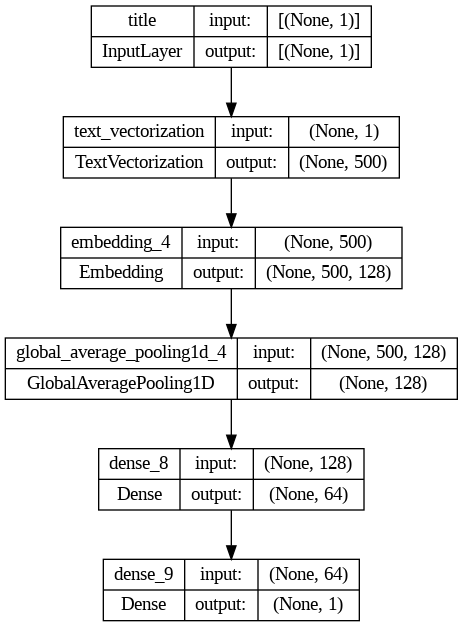

In [ ]:
from tensorflow.keras.utils import plot_model

# Let's take a look at the model structure
plot_model(model_title, show_shapes=True, show_layer_names=True)

Next we can define a function to plot the training history of the model.

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Create two subfigures
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    # Plot accuracy history
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend() # Add legend
    # Add title and labels
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    # Plot loss history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend() # Add legend
    # Add title and labels
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.show()


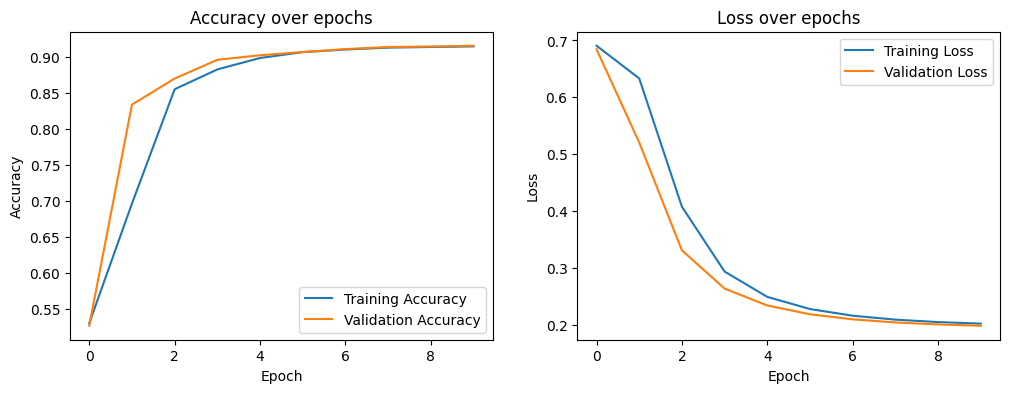

In [ ]:
plot_history(history)

The graph shows no sign of overfitting, and our model is doing well. Next we will do the same to the following two models.

In [ ]:
# Train model2
history1 = model_text.fit(train_dataset
                          , validation_data=val_dataset
                          , epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


180/180 [==============================] - 14s 71ms/step - loss: 0.6277 - accuracy: 0.6702 - val_loss: 0.4567 - val_accuracy: 0.8609
Epoch 2/10
180/180 [==============================] - 2s 13ms/step - loss: 0.3547 - accuracy: 0.8650 - val_loss: 0.3074 - val_accuracy: 0.8766
Epoch 3/10
180/180 [==============================] - 2s 13ms/step - loss: 0.2747 - accuracy: 0.8902 - val_loss: 0.2632 - val_accuracy: 0.8905
Epoch 4/10
180/180 [==============================] - 2s 12ms/step - loss: 0.2463 - accuracy: 0.8990 - val_loss: 0.2437 - val_accuracy: 0.9159
Epoch 5/10
180/180 [==============================] - 2s 12ms/step - loss: 0.2322 - accuracy: 0.9023 - val_loss: 0.2343 - val_accuracy: 0.9175
Epoch 6/10
180/180 [==============================] - 3s 18ms/step - loss: 0.2243 - accuracy: 0.9046 - val_loss: 0.2293 - val_accuracy: 0.9186
Epoch 7/10
180/180 [==============================] - 3s 15ms/step - loss: 0.2197 - accuracy: 0.9076 - val_loss: 0.2266 - val_accuracy: 0.9168
Epoch 8/1

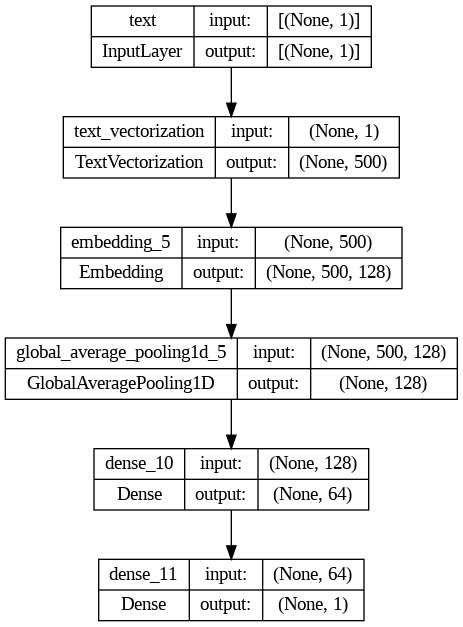

In [ ]:
# Let's take a look at the model structure
plot_model(model_text, show_shapes=True, show_layer_names=True)

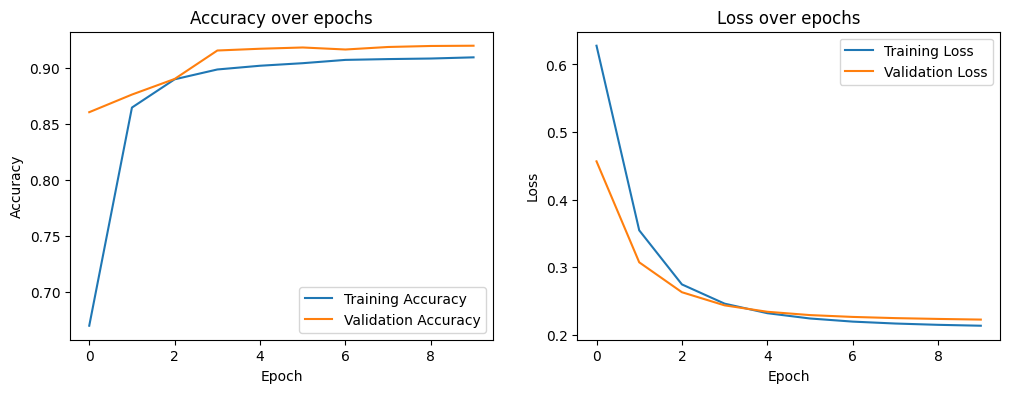

In [ ]:
plot_history(history1)

In [ ]:
# Train model3
history2 = model_combined.fit(train_dataset
                          , validation_data=val_dataset
                          , epochs=10)


Epoch 1/10
180/180 [==============================] - 26s 89ms/step - loss: 0.6098 - accuracy: 0.6824 - val_loss: 0.3995 - val_accuracy: 0.9047
Epoch 2/10
180/180 [==============================] - 4s 24ms/step - loss: 0.2772 - accuracy: 0.9193 - val_loss: 0.2032 - val_accuracy: 0.9492
Epoch 3/10
180/180 [==============================] - 3s 17ms/step - loss: 0.1793 - accuracy: 0.9465 - val_loss: 0.1473 - val_accuracy: 0.9609
Epoch 4/10
180/180 [==============================] - 3s 16ms/step - loss: 0.1402 - accuracy: 0.9581 - val_loss: 0.1182 - val_accuracy: 0.9661
Epoch 5/10
180/180 [==============================] - 5s 26ms/step - loss: 0.1161 - accuracy: 0.9638 - val_loss: 0.0994 - val_accuracy: 0.9712
Epoch 6/10
180/180 [==============================] - 3s 16ms/step - loss: 0.0993 - accuracy: 0.9678 - val_loss: 0.0862 - val_accuracy: 0.9746
Epoch 7/10
180/180 [==============================] - 4s 20ms/step - loss: 0.0872 - accuracy: 0.9721 - val_loss: 0.0766 - val_accuracy: 0.977

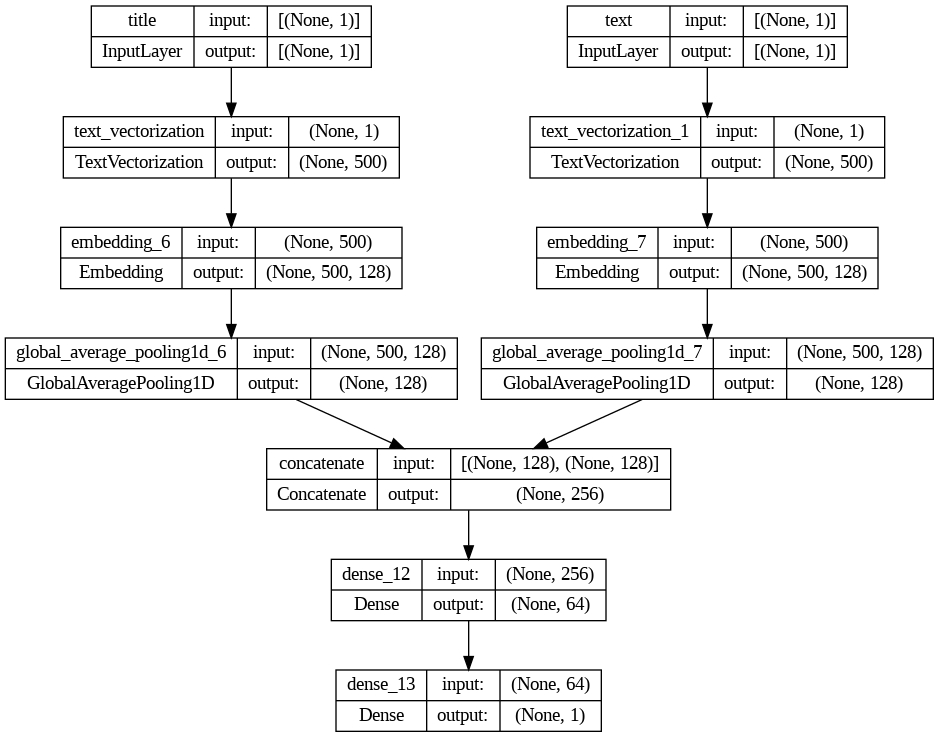

In [ ]:
# Let's take a look at the model structure
plot_model(model_combined, show_shapes=True, show_layer_names=True)

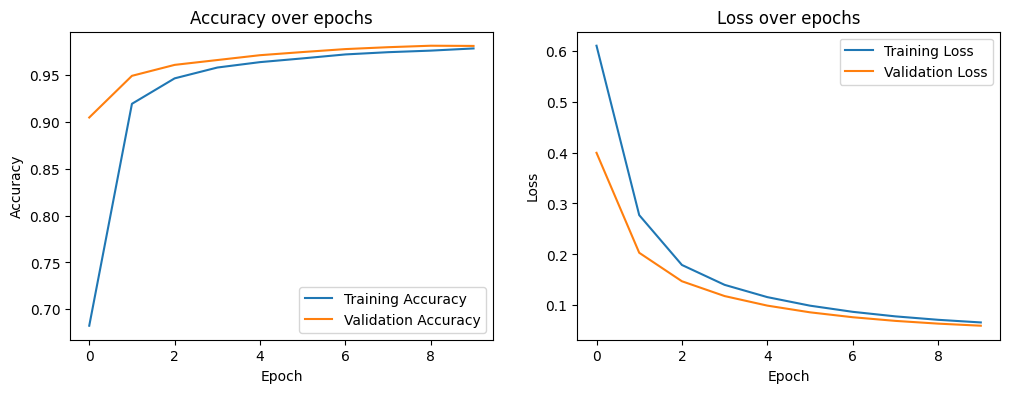

In [ ]:
plot_history(history2)

From the result, we can tell that the combined model, which uses title and text as input, has the highest accuracy of 0.9813.

### Evaluation of the model

In this section, we will evaluate the model on an unseen test set.

In [ ]:
# Retrieve data from URL
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"
df_test = pd.read_csv(test_url)
# Make testset
test_dataset = make_dataset(df_test)

In [ ]:
# Get accuracy
loss, accuracy = model_combined.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

225/225 [==============================] - 3s 11ms/step - loss: 0.0689 - accuracy: 0.9751
Test Loss: 0.06891239434480667, Test Accuracy: 0.9751436710357666


### Visualization of Embedding

To better understand the text embedding, we can map the vectors to 2D with PCA, and intepret the relative locations of the words. Words with similar semantic meaning would tend to be closer in distance. 

In [ ]:
# Get embedding weights from model
embedding_layer = model_combined.get_layer('embedding_6')
embeddings = embedding_layer.get_weights()[0]

In [ ]:
from sklearn.decomposition import PCA

# Map the embeddings to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

In [ ]:
# Get vocab lists and determine words of interest for visualization
vocab = title_vectorize_layer.get_vocabulary()[:128]
word_indices = {word: idx for idx, word in enumerate(vocab)}
words_to_visualize = ['trump', 'obama', 'president', 'iran', 'uk']

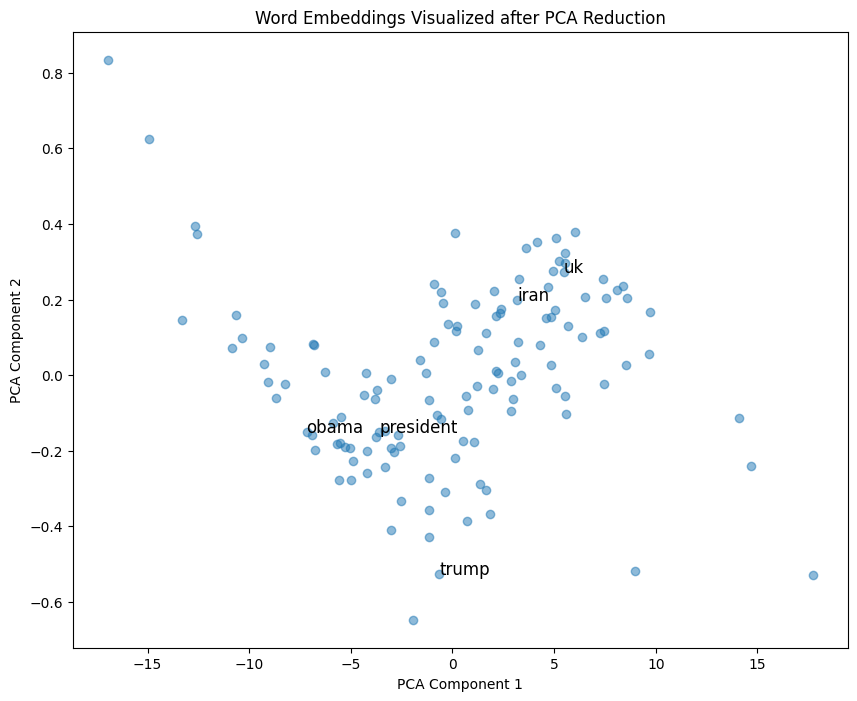

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_embeddings(embeddings, vocabulary, words_to_visualize):
    # Reducing dimensionality of embeddings
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Create a dictionary for word indices
    word_indices = {word: idx for idx, word in enumerate(vocabulary)}

    # Get x and y coordinates
    x = reduced_embeddings[:, 0]
    y = reduced_embeddings[:, 1]

    # Plotting
    plt.figure(figsize=(10, 8))
    plt.scatter(x, y, alpha=0.5)

    # Annotate in the graph
    for word in words_to_visualize:
        if word in word_indices:
            idx = word_indices[word]
            plt.annotate(word, (x[idx], y[idx]), fontsize=12)
        else:
            print(f"Word '{word}' not found in vocabulary.")
    # Add labels and title
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('Word Embeddings Visualized after PCA Reduction')
    plt.show()

plot_embeddings(embeddings, vocab, words_to_visualize)

We can see that Obama, President, and Trump are close as they are related to politics. UK and Iran are close since they are both nations.